# Evolution of COVID-19
> Data from John Hopkins University

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]

In [0]:
#hide
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np
import math
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
plt.style.use('seaborn')
import datetime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [136]:
#hide
pip install countryinfo

In [137]:
#hide
from countryinfo import CountryInfo
#country = CountryInfo('United States')
#CountryInfo('United States').population()
CountryInfo('Portugal').population()

10477800

In [0]:
#hide
def display_all(df,Nrows=5,Ncolumns=1000):
    # função para não cortar colunas ao visualizar    
    import pandas as pd
    from IPython.display import display
    with pd.option_context("display.max_rows", Nrows): 
        with pd.option_context("display.max_columns", Ncolumns): 
            display(df)




def format_graph(size_title, title, subtitle, ax, graph_type = 1):

  # Texto
  ax.text(0, 1.15, title,
          transform=ax.transAxes, size=size_title, weight=600, ha='left', va='top')    
  ax.text(0, 1.06, subtitle, transform=ax.transAxes, size=size_title-5, color='#777777')
  ax.text(0.7, 0.05, 'Vasco Mano; Source: John Hopkins', transform=ax.transAxes,
          color='#777777', size=size_title-8, ha='left', va='bottom' ,bbox=dict(facecolor='white', alpha=1.0, edgecolor='white'))  

  # formating
  from matplotlib.ticker import FormatStrFormatter
  ax.xaxis.set_ticks_position('top')
  ax.tick_params(axis='x', colors='#777777', labelsize = size_title-8)

  ax.tick_params(axis="y", labelsize = size_title-8)

  if ((graph_type == 3) or (graph_type == 4)):
    if (graph_type == 4): ax.yaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_ylabel('Log scale', fontsize=size_title-8)
    ax.set_yscale('log')
  else:
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))    

  ax.grid(which='both', axis='x', linestyle='-')
  ax.grid(color='#777777', linestyle=(0, (5, 5)), linewidth=0.3)
  ax.grid(True)
  ax.margins(0, 0.01)
  plt.box(False)

  #plt.legend(loc=2, prop={'size': size_title-8}, frameon=False)
  return

In [0]:
#hide
def data_covid(case, graph_type):
  # Data
  if case == 1: 
    df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
    DAY_ZERO = 100
    title = 'Number of confirmed cases of COVID-19'
    miny = 100
  if case == 2: 
    df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

    DAY_ZERO = 10
    title = 'Number of deaths caused by COVID-19'
    miny = 10
  if case == 3: 
    df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
    title = 'Number of people that recovered from COVID-19'
    DAY0 = False
    miny = 1

  if graph_type == 2 or graph_type == 4: title = title + ' per 100 000 population'

  return df, title, DAY_ZERO


In [0]:
#hide
def day_zero(df,country,N0):

  cols = df.keys()
  cols = df.loc[country, cols[3]:cols[-1]].keys()

  flag = 0
  day_0 = 0
  for xi in range(len(cols)):
    if df[cols[xi]][country] > flag: 
      flag = df[cols[xi]][country]
    if flag >= N0: 
      day_0 = xi+1
      break
    else:
      continue
  return day_0

In [0]:
#hide
def plot_country(country, ax, day=1, case=1, graph_type=1, LINE_WIDTH=3, MARKERZISE=24, LINESTYLE='solid', color='black', DAY0=True, DAY_LABEL=2, maxy = 60000):
  '''
  case 1: confirmed
  case 2: death
  case 3: recoveries

  graph_type 1: linear
  graph_type 2: per 100 000 habitantes
  graph_type 3: log scale
  graph_type 4: log scale per 100 000 habitantes
  '''

  if ((case !=1) and (case !=2) and (case !=3)): 
    print('Error: Case number')
    return
  if ((graph_type !=1) and (graph_type !=2) and (graph_type !=3) and (graph_type !=4)): 
    print('Error: graph_type number')
    return


  import matplotlib.dates as mdates
  from dateutil import rrule, parser
  from matplotlib.ticker import FormatStrFormatter
  size_title = 24
  
  # data
  df, title, DAY_ZERO = data_covid(case, graph_type)
  df_group = df.groupby(['Country/Region']).sum()
  if DAY0: day0 = day_zero(df_group,country,DAY_ZERO)

  cols = df.keys()
  datemax = cols[-1]
  datemax = datetime.datetime.strptime(datemax, '%m/%d/%y').strftime('%d/%m/%y')
  subtitle = f'Date: {datemax}'

  if country != 'US':
    NPeopleAPI = CountryInfo(country)
    NPeople = NPeopleAPI.population()
  else:
    NPeopleAPI = CountryInfo('United States')
    NPeople = NPeopleAPI.population()

  # Dates
  cols = df.keys()
  df_dates = df.loc[:, cols[4]:cols[-1]]
  df_dates = df_dates.keys()
  datemin = df_dates[0]
  datemax = df_dates[day]
  mydates = list(rrule.rrule(rrule.DAILY,
                             dtstart=parser.parse(datemin),
                             until=parser.parse(datemax)))
  
  if day > df_group.loc[country][day0+2:].size: day = df_group.loc[country][day0+2:].size
  mydates_day0 = np.arange(day)

  # Pre Processing  
  y = []
  for i in range(len(mydates_day0)):
    if ((graph_type==2) or (graph_type==4)):
      x = df_group.loc[country][day0+2+i]/float(NPeople)
      x = x*100000
    else:
      x = df_group.loc[country][day0+2+i]
    y.append(x)

  # Plot
  ax.plot(mydates_day0, y, linewidth=LINE_WIDTH, markersize=MARKERZISE, linestyle = LINESTYLE, color=color, label= f'{country}')

  # Format
  format_graph(size_title, title, subtitle, ax, graph_type)
  ax.set_facecolor('white')
  fig.patch.set_facecolor('white')

  return

In [0]:
#hide
def plot_slope(SLOPE=2, LINE_WIDTH=1, MARKERZISE=24, LINESTYLE='dashed', COLOR='grey', N0=100):
  NDAY = 100
  X = [0 , NDAY]
  Y = [N0 , N0*SLOPE**(NDAY)]
  #print(f'N0 = {N0}')
  #print(f'N0*SLOPE^(NDAY) = {N0*SLOPE**(NDAY)}')
  ax.plot(X, Y, linewidth=LINE_WIDTH, markersize=MARKERZISE, linestyle = LINESTYLE, color=COLOR)
  ax.set_yscale('log')


In [0]:
#hide
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
#confirmed_df['3/18/20'][59] = 642
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

cols = confirmed_df.keys()

Last update:

In [144]:
#hide_input
lastdate = cols[-1]
lastdate = datetime.datetime.strptime(lastdate, '%m/%d/%y').strftime('%d/%m/%y')
print(lastdate)

31/03/20


In [0]:
#hide
cols = confirmed_df.keys()

confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
total_recovered = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)
    total_recovered.append(recovered_sum)


# Number of confirmed cases and deaths worldwide


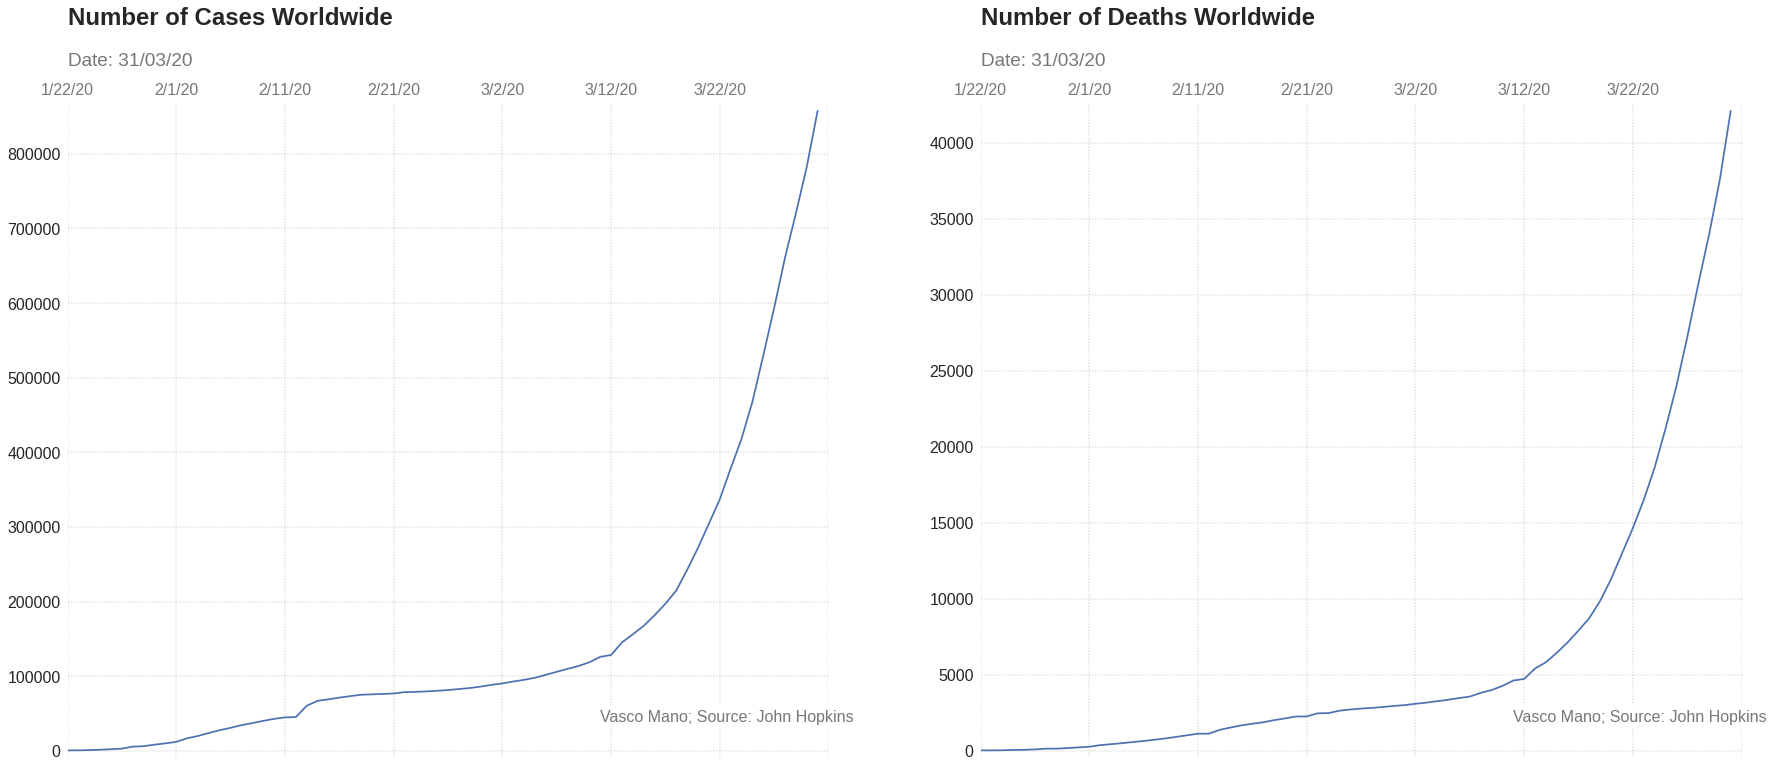

In [170]:
#hide_input
subtitle = str(f'Date: {lastdate}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))

# ----------
ax1.plot(dates,world_cases)
format_graph(24, 'Number of Cases Worldwide', subtitle, ax1)
ax1.set_xticks(np.arange(0, 80, step=10))  # Set label locations.
ax1.set_facecolor('white')
fig.patch.set_facecolor('white')

# ----------
ax2.plot(dates,total_deaths)
format_graph(24, 'Number of Deaths Worldwide', subtitle, ax2)
ax2.set_xticks(np.arange(0, 80, step=10))  # Set label locations.
ax2.set_facecolor('white')
fig.patch.set_facecolor('white')

#plt.tight_layout()

# Selected Countries

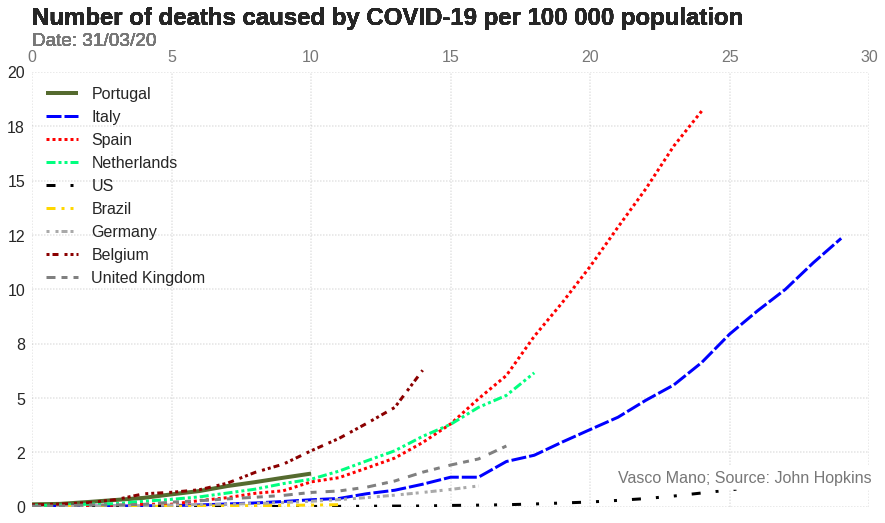

In [153]:
#hide
def frames(NDAYS, ax, CASE=1, graph_type=1):
  '''
  case 1: confirmed
  case 2: death
  case 3: recoveries

  graph_type 1: linear
  graph_type 2: per 100 000 habitantes
  graph_type 3: log scale
  graph_type 4: log scale per 100 000 habitantes
  '''
  import matplotlib.ticker as ticker
  size_title = 24

  #ax.clear()
  plot_country(       'Portugal', ax, day=NDAYS, case=CASE, graph_type=graph_type, LINE_WIDTH=4, MARKERZISE=24, color='darkolivegreen', LINESTYLE=(0, ())                , DAY0=True)
  plot_country(          'Italy', ax, day=NDAYS, case=CASE, graph_type=graph_type, LINE_WIDTH=3, MARKERZISE=24, color='blue'          , LINESTYLE=(0, (5, 1))            , DAY0=True)
  plot_country(          'Spain', ax, day=NDAYS, case=CASE, graph_type=graph_type, LINE_WIDTH=3, MARKERZISE=24, color='red'           , LINESTYLE=(0, (1, 1))            , DAY0=True)
  plot_country(    'Netherlands', ax, day=NDAYS, case=CASE, graph_type=graph_type, LINE_WIDTH=3, MARKERZISE=24, color='springgreen'   , LINESTYLE=(0, (3, 1, 1, 1, 1, 1)), DAY0=True)
  plot_country(             'US', ax, day=NDAYS, case=CASE, graph_type=graph_type, LINE_WIDTH=3, MARKERZISE=24, color='black'         , LINESTYLE=(0, (3, 5, 1, 5, 1, 5)), DAY0=True)
  plot_country(         'Brazil', ax, day=NDAYS, case=CASE, graph_type=graph_type, LINE_WIDTH=3, MARKERZISE=24, color='gold'          , LINESTYLE=(0, (3, 2, 1, 2, 1, 2)), DAY0=True)
  plot_country(        'Germany', ax, day=NDAYS, case=CASE, graph_type=graph_type, LINE_WIDTH=3, MARKERZISE=24, color='darkgray'      , LINESTYLE=(0, (1, 2, 1, 1, 2, 1)), DAY0=True)
  plot_country(        'Belgium', ax, day=NDAYS, case=CASE, graph_type=graph_type, LINE_WIDTH=3, MARKERZISE=24, color='darkred'       , LINESTYLE=(0, (1, 1, 2, 2, 1, 1)), DAY0=True)
  plot_country( 'United Kingdom', ax, day=NDAYS, case=CASE, graph_type=graph_type, LINE_WIDTH=3, MARKERZISE=24, color='gray'          , LINESTYLE=(0, (3, 2, 2, 2, 2, 3)), DAY0=True)

  #ax.text(0.165, 0.92, "Cases double\nevery day", transform=ax.transAxes, size=24-5, color='#777777')
  #plot_slope(SLOPE=2)       # duplica diariamente
  #ax.text(0.36, 0.90, "every 2 days", transform=ax.transAxes, size=24-5, color='#777777')
  #plot_slope(SLOPE=(1.5))   # duplica 2 dias
  #ax.text(0.545, 0.885, "every 3 days", transform=ax.transAxes, size=24-5, color='#777777')
  #plot_slope(SLOPE=(1.334)) # duplica 3 dias
  #ax.text(0.85, 0.81, "every 5 days", transform=ax.transAxes, size=24-5, color='#777777')
  #plot_slope(SLOPE= 1.2)    # duplica 5 dias  

  from matplotlib.ticker import FormatStrFormatter
  if (graph_type ==4):
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.02f'))
  else:
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

  ax.legend(loc=2, prop={'size': size_title-8}, frameon=False)

  ax.set_xlim(0,   30)
  miny = 0
  if (graph_type == 3): 
    miny = 10
    if CASE == 1: miny = 100
  if (graph_type == 4): 
    miny = 0.01

  if CASE == 1:
    if graph_type == 2 or graph_type == 4:
      ax.set_ylim(miny, 220)
    else:
      ax.set_ylim(miny, 200000)
  elif CASE == 2:
    if graph_type == 2 or graph_type == 4:
      ax.set_ylim(miny, 20)
    else:
      ax.set_ylim(miny,10000)

  #plt.show()

# --------

fig, ax = plt.subplots( 1, 1, figsize=(15, 8))
frames(30, ax, CASE=2, graph_type=2)

## Number of confirmed cases and deaths

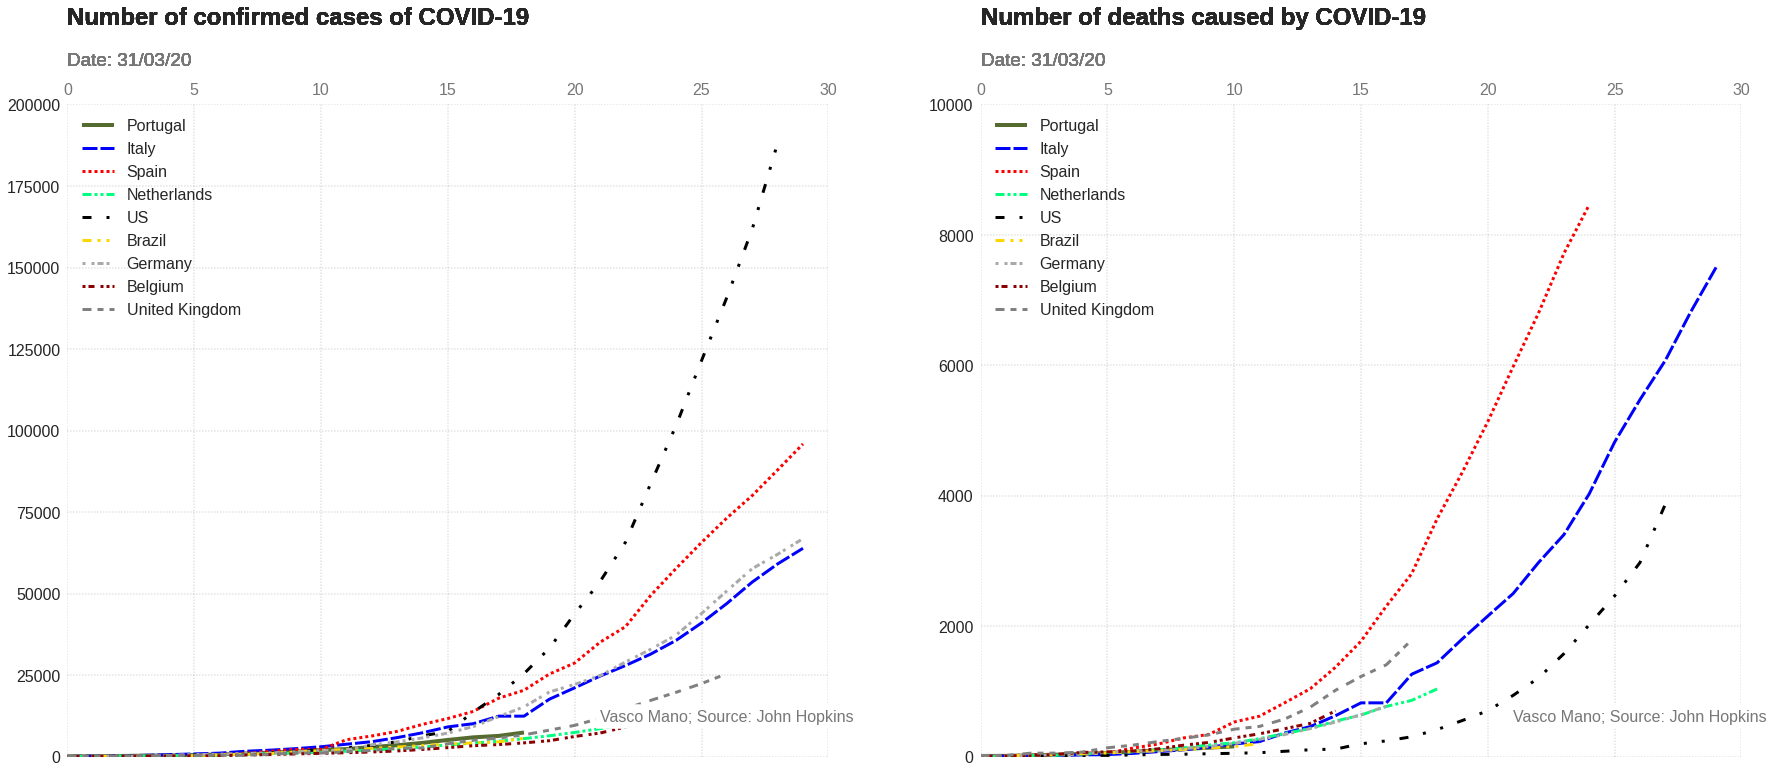

In [154]:
#hide_input
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))

#plt.subplot(1, 2, 1)
frames(30, ax1, CASE=1, graph_type=1)

#plt.subplot(1, 2, 2)
frames(30, ax2, CASE=2, graph_type=1)

#plt.tight_layout()

## Number of confirmed cases and deaths per 100 000 population

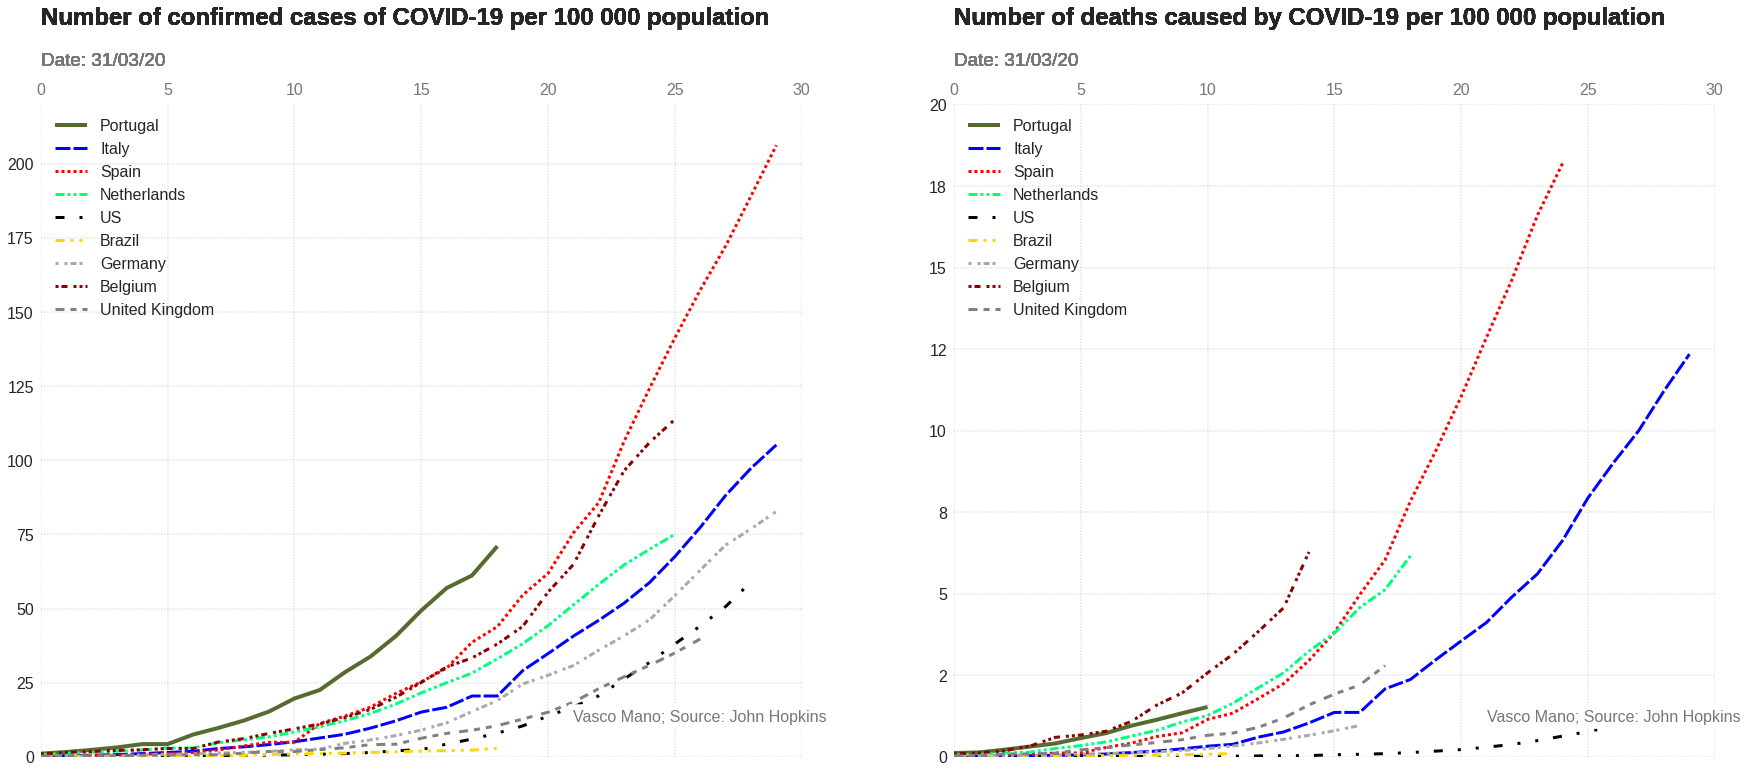

In [155]:
#hide_input
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))

#plt.subplot(1, 2, 1)
frames(30, ax1, CASE=1, graph_type=2)

#plt.subplot(1, 2, 2)
frames(30, ax2, CASE=2, graph_type=2)

#plt.tight_layout()


## Number of confirmed cases and deaths - Log scale

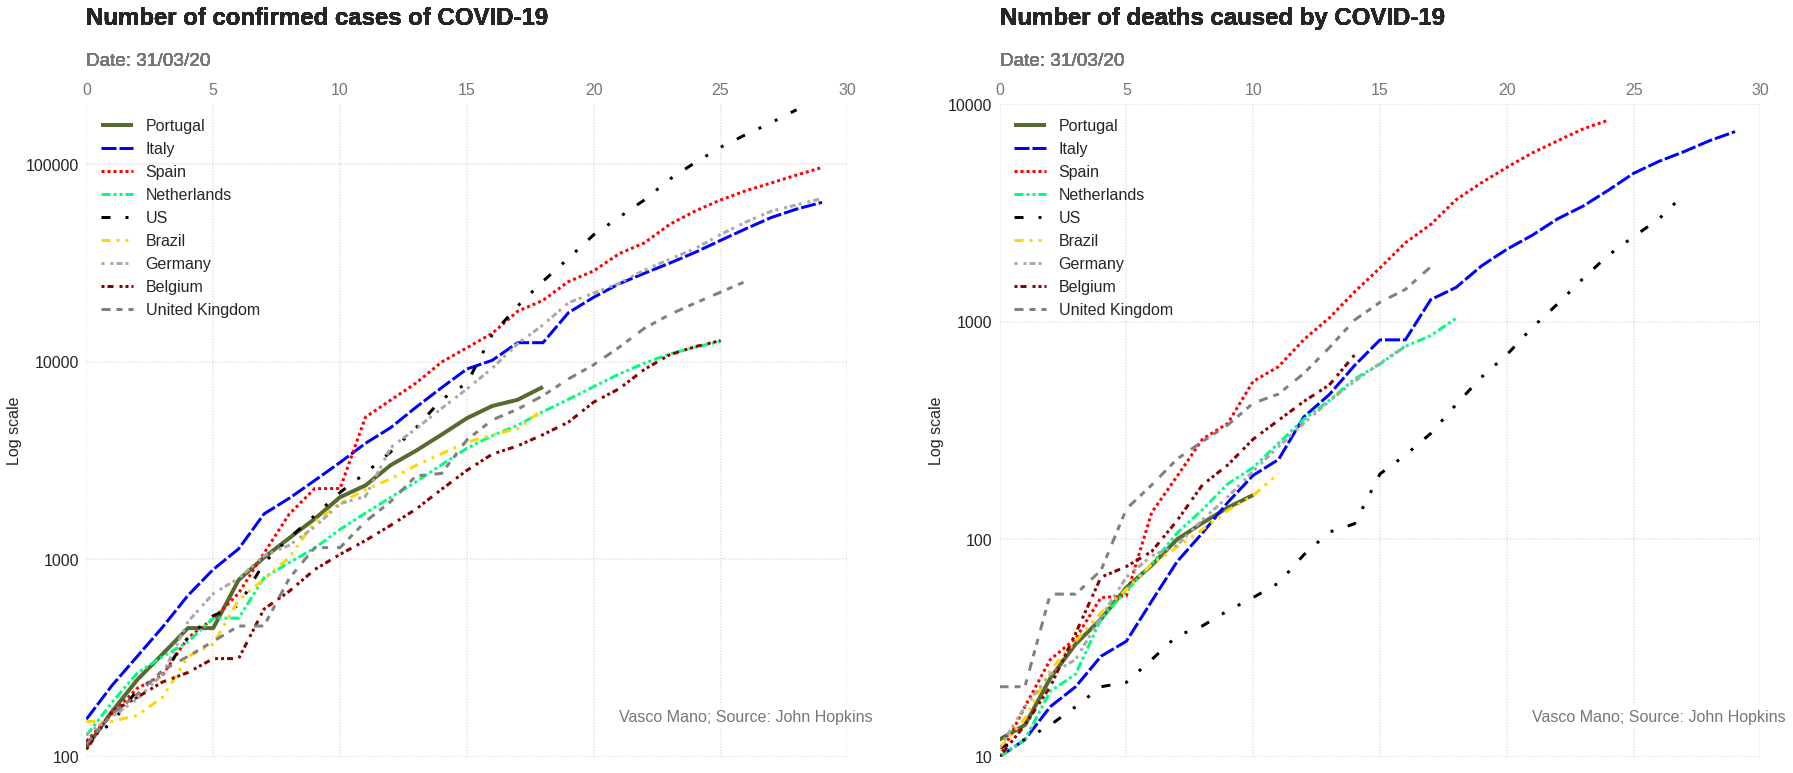

In [156]:
#hide_input
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))

#plt.subplot(1, 2, 1)
frames(30, ax1, CASE=1, graph_type=3)

#plt.subplot(1, 2, 2)
frames(30, ax2, CASE=2, graph_type=3)

#plt.tight_layout()

## Number of confirmed cases and deaths per 100 000 population - Log scale

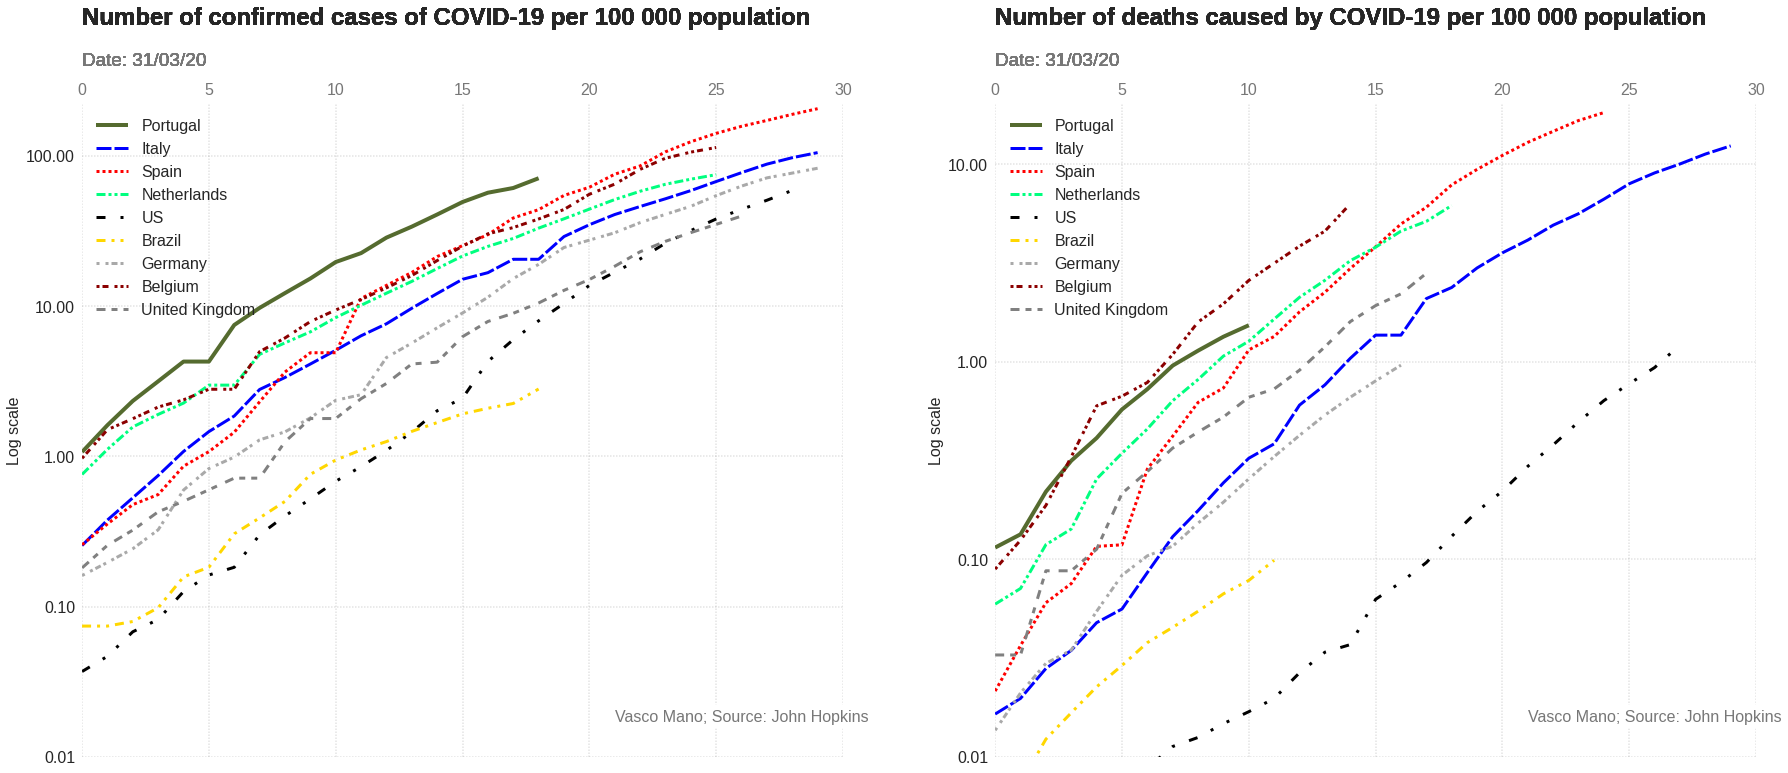

In [157]:
#hide_input
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))

#plt.subplot(1, 2, 1)
frames(30, ax1, CASE=1, graph_type=4)

#plt.subplot(1, 2, 2)
frames(30, ax2, CASE=2, graph_type=4)

#plt.tight_layout()